Explanation:
Data Preparation:

Load the data and select the relevant features.
Handle missing values and normalize the data.
Sequence Creation:

Create sequences with a defined lookback period for model training.
Separate the target column (error code) for separate scaling.
Train-Test Split:

Split the data into training and testing sets.
Model Building:

Build an LSTM model with dropout layers for regularization.
Compile the model with a loss function and optimizer.
Training:

Train the model using early stopping, learning rate reduction, and model checkpointing to avoid overfitting.
Prediction:

Make predictions on the test data and inverse transform them to the original scale.
Evaluation:

Evaluate the model performance using mean squared error and visualize true vs predicted values.
Anomaly Detection:

Calculate the absolute differences between true and predicted values.
Define a threshold for anomalies and identify them.
Plot the anomalies on a graph for visualization.
By following this algorithm, you can predict errors before they happen and visualize the results effectively. You can experiment with different models and hyperparameters to improve the prediction accuracy and anomaly detection performance.


Algorithm for Predicting Errors Before They Happen
Step 1: Data Preparation
Load Data: Load your dataset and the selected columns.
Feature Selection: Ensure all selected columns are numeric.
Handle Missing Values: Drop or impute missing values.
Normalize Data: Scale the data using MinMaxScaler.
Step 2: Create Sequences
Define Lookback Period: Set the number of past time steps to consider.
Create Sequences: Create sequences of data using the lookback period to predict the future steps.
Step 3: Train-Test Split
Split Data: Divide the data into training and testing sets.
Step 4: Model Building
Choose Model: Select an appropriate model (e.g., LSTM, GRU, CNN-LSTM).
Define Architecture: Build the model architecture.
Compile Model: Compile the model with a suitable loss function and optimizer.
Step 5: Training
Train Model: Train the model using the training data.
Use Callbacks: Implement callbacks like EarlyStopping, ReduceLROnPlateau, and ModelCheckpoint.
Step 6: Prediction
Make Predictions: Use the trained model to make predictions on the test data.
Inverse Transform: Inverse transform the predictions to the original scale.
Step 7: Evaluation
Evaluate Model: Calculate metrics like Mean Squared Error (MSE).
Visualize Results: Plot true vs. predicted values and identify anomalies.
Step 8: Anomaly Detection
Calculate Differences: Compute the absolute differences between true and predicted values.
Set Threshold: Define a threshold for anomalies.
Identify Anomalies: Detect anomalies where differences exceed the threshold.
Plot Anomalies: Visualize the anomalies.

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf

In [10]:


# Load the main dataset
data_path = 'data2.csv'  # Adjust the path if necessary
data = pd.read_csv(data_path)

# Load the selected columns from the specified path
selected_columns_path = 'AirEau_features_lag15.csv'  # Adjust the path if necessary
selected_columns_df = pd.read_csv(selected_columns_path)

# Select only the feature column
selected_columns = selected_columns_df['Feature'].tolist()

# Ensure 'Error Code' is included in the selected columns
if 'Error Code' not in selected_columns:
    selected_columns.append('Error Code')

# Ensure all selected columns are numeric
data_selected = data[selected_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows with any NaN values
data_selected.dropna(inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_selected)

In [11]:


# Separate the target column for separate scaling
target_scaler = MinMaxScaler()
scaled_data[:, selected_columns.index('Error Code')] = target_scaler.fit_transform(
    data_selected['Error Code'].values.reshape(-1, 1)).flatten()

# Define the lookback period (number of previous time steps to consider)
lookback = 60  # Number of past time steps to look at
LABELS = 6  # Number of future time steps to predict

# Create sequences of data
def create_sequences(data, lookback, labels, target_idx):
    X, y = [], []
    for i in range(len(data) - lookback - labels + 1):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback:i + lookback + labels, target_idx])
    return np.array(X), np.array(y)

# The target column index
target_idx = selected_columns.index('Error Code')

X, y = create_sequences(scaled_data, lookback, LABELS, target_idx)

# Reshape y to have the same sequence length as the model's output
y = y.reshape((y.shape[0], y.shape[1]))

In [12]:


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)

# Print the shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Create a Sequential model
model = Sequential()

# Add LSTM layers with Dropout for regularization
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))

# Add a Dense layer to match the output size
model.add(Dense(LABELS))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Display the model summary
model.summary()

# Callbacks for early stopping, learning rate reduction, and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

X_train shape: (93353, 60, 26), y_train shape: (93353, 6)
X_test shape: (10373, 60, 26), y_test shape: (10373, 6)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 100)           50800     
                                                                 
 dropout_2 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 306       
                                                                 
Total params: 81306 (317.60 KB)
Trainable params: 81306 (317.60 KB)
Non-

2024-07-03 22:48:48.003499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-03 22:48:48.254616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-03 22:48:48.341875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-03 22:48:48.488745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-03 22:48:48.644314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-03 22:49:26.544812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-03 22:49:26.635557: I tensorflow/core/grappler/optimizers/cust

1459/1459 - 41s - loss: 4.8314e-04 - val_loss: 1.2583e-04 - lr: 0.0010 - 41s/epoch - 28ms/step


/Users/skalaliya/anaconda3/envs/tensor_v1/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


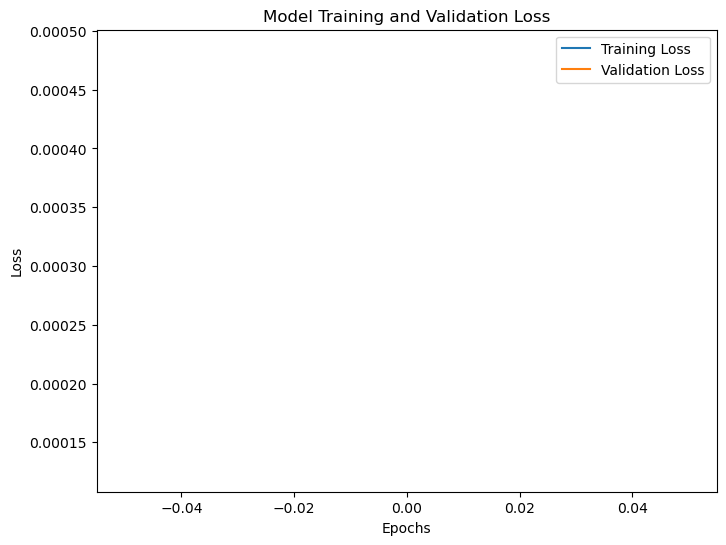

In [13]:


# Train the model with batch size of 64
history = model.fit(X_train, y_train, epochs=1, batch_size=64, validation_data=(X_test, y_test), 
                    verbose=2, shuffle=False, callbacks=[early_stopping, reduce_lr, model_checkpoint])

# Plot training loss and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2024-07-03 22:49:28.936164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-03 22:49:29.016598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-03 22:49:29.086823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


325/325 [==============================] - 3s 9ms/step
Mean Squared Error: 0.1722609317153276


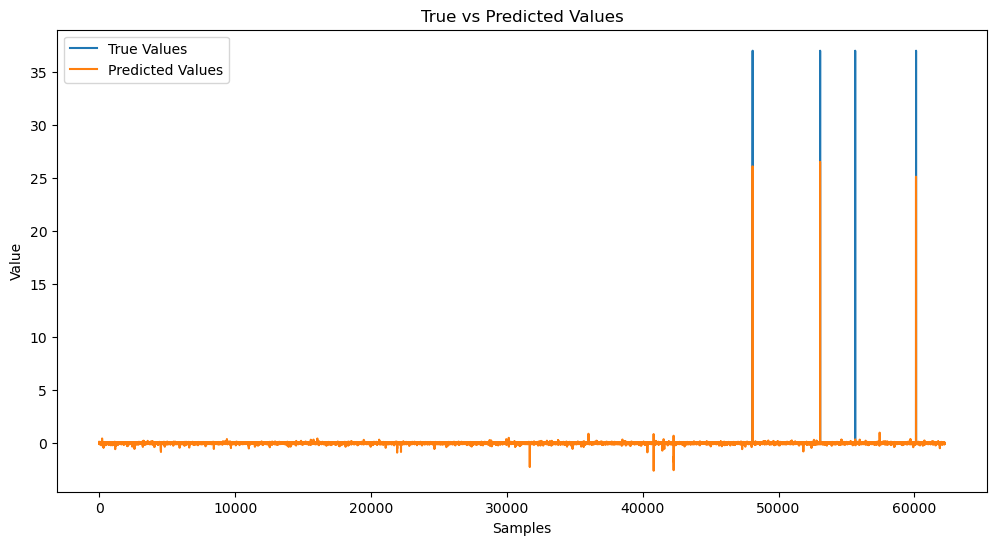

In [14]:

# Load the best model
model.load_weights('best_model.h5')

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and true values to get original scale values
y_test_inverse = target_scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_inverse = target_scaler.inverse_transform(predictions.reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_inverse, predictions_inverse)
print(f'Mean Squared Error: {mse}')

# Plot true vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='True Values')
plt.plot(predictions_inverse, label='Predicted Values')
plt.title('True vs Predicted Values')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()
plt.show()

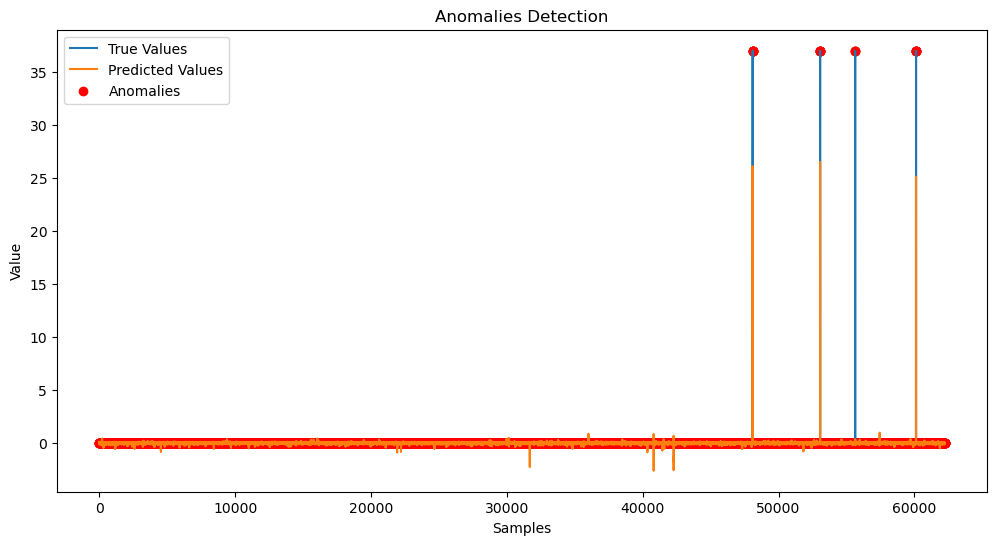

In [15]:



# Calculate the absolute differences
differences = np.abs(y_test_inverse - predictions_inverse)

# Define a threshold for anomalies (this can be adjusted based on your data)
threshold = 0.05  # Example threshold

# Identify the anomalies
anomalies = differences > threshold

# Plot anomalies
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='True Values')
plt.plot(predictions_inverse, label='Predicted Values')
plt.scatter(np.where(anomalies)[0], y_test_inverse[anomalies], color='red', label='Anomalies')
plt.title('Anomalies Detection')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()
plt.show()


1. GRU (Gated Recurrent Unit):


2024-07-03 22:52:16.018254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-03 22:52:16.268317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-03 22:52:16.347099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-03 22:52:16.495546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-03 22:52:16.626239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-03 22:52:50.484681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-03 22:52:50.552374: I tensorflow/core/grappler/optimizers/cust

1459/1459 - 37s - loss: 0.0012 - val_loss: 8.2803e-05 - 37s/epoch - 25ms/step


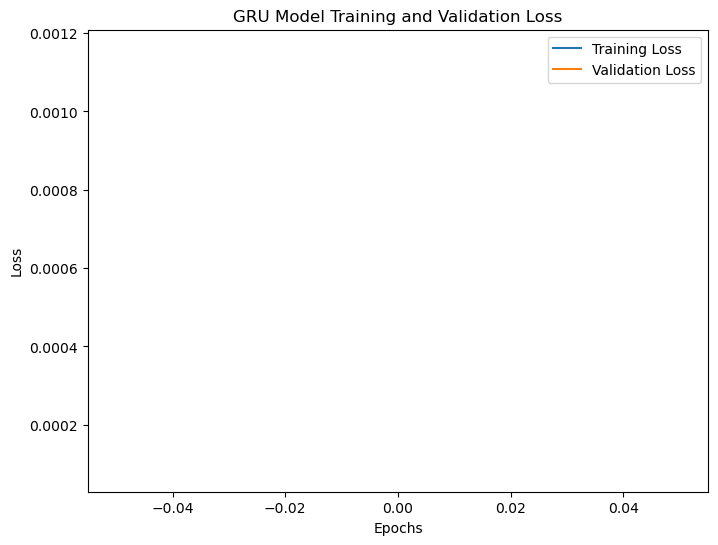

  1/325 [..............................] - ETA: 1:33

2024-07-03 22:52:52.367990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-03 22:52:52.428894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-03 22:52:52.474204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


325/325 [==============================] - 3s 8ms/step


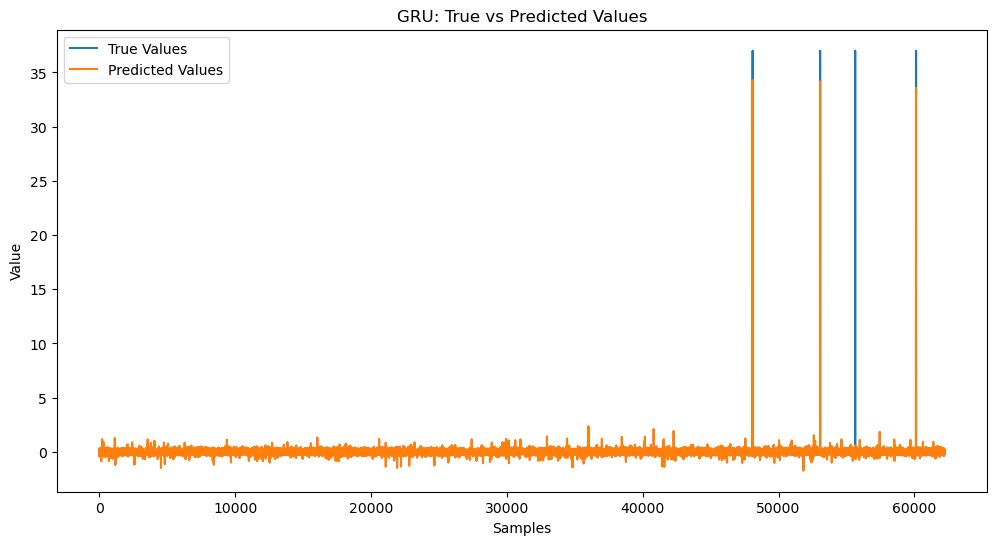

In [17]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout

# Create a Sequential model
model_gru = Sequential()

# Add GRU layers with Dropout for regularization
model_gru.add(GRU(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(50, return_sequences=False))
model_gru.add(Dropout(0.2))

# Add a Dense layer to match the output size
model_gru.add(Dense(LABELS))

# Compile the model
model_gru.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history_gru = model_gru.fit(X_train, y_train, epochs=1, batch_size=64, validation_data=(X_test, y_test), verbose=2)

# Plot training loss and validation loss - Training Loss Curves:

plt.figure(figsize=(8, 6))
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('GRU Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predictions vs. True Values:
# Make predictions
predictions_gru = model_gru.predict(X_test)

# Inverse transform the predictions and true values to get original scale values
y_test_inverse_gru = target_scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_inverse_gru = target_scaler.inverse_transform(predictions_gru.reshape(-1, 1))

# Plot true vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse_gru, label='True Values')
plt.plot(predictions_inverse_gru, label='Predicted Values')
plt.title('GRU: True vs Predicted Values')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()
plt.show()


2. CNN-LSTM:


2024-07-03 22:53:01.078756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-03 22:53:01.327839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-03 22:53:01.417265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-03 22:53:01.548196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-03 22:53:01.701388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-03 22:53:25.348285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-03 22:53:25.441475: I tensorflow/core/grappler/optimizers/cust

1459/1459 - 26s - loss: 5.6081e-04 - val_loss: 1.4850e-04 - 26s/epoch - 18ms/step


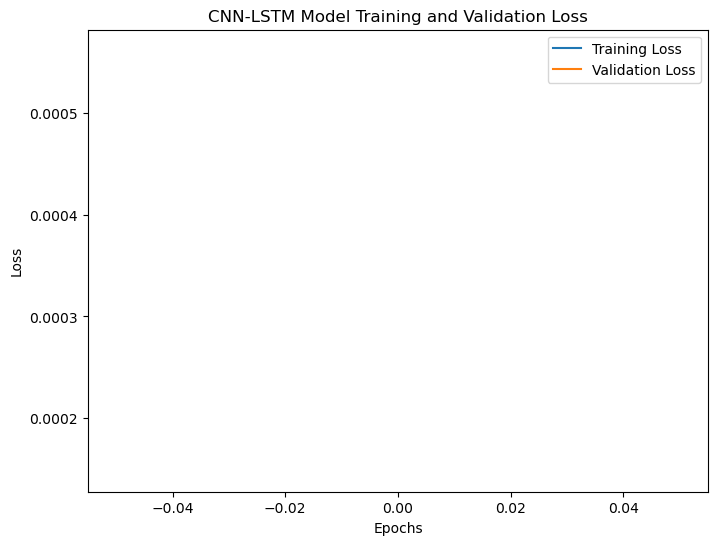

2024-07-03 22:53:27.045543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-03 22:53:27.131749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-03 22:53:27.210901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


325/325 [==============================] - 2s 5ms/step


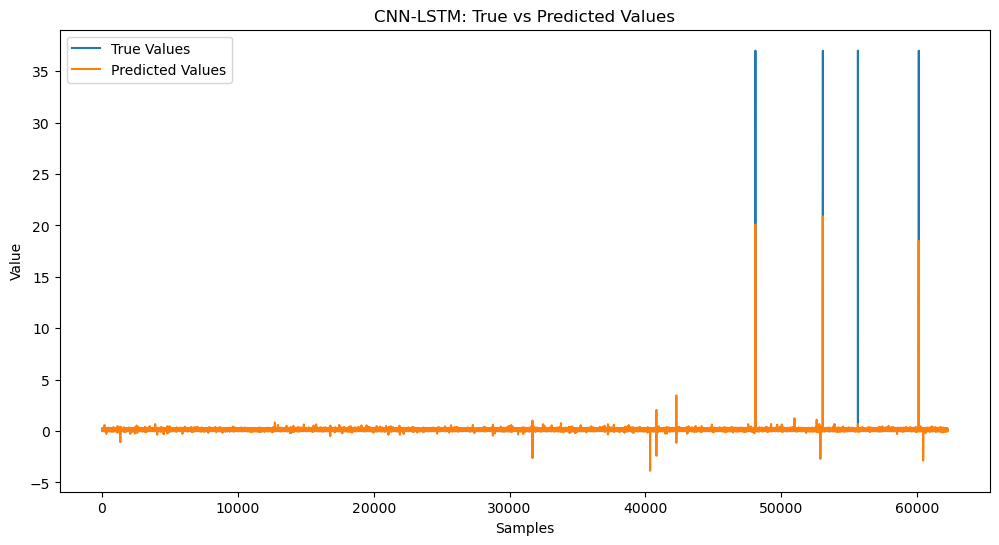

In [18]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

# Create a Sequential model
model_cnn_lstm = Sequential()

# Add Conv1D and MaxPooling1D layers
model_cnn_lstm.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_cnn_lstm.add(MaxPooling1D(pool_size=2))

# Add LSTM layers with Dropout for regularization
model_cnn_lstm.add(LSTM(50, return_sequences=True))
model_cnn_lstm.add(Dropout(0.2))
model_cnn_lstm.add(LSTM(50, return_sequences=False))
model_cnn_lstm.add(Dropout(0.2))

# Add a Dense layer to match the output size
model_cnn_lstm.add(Dense(LABELS))

# Compile the model
model_cnn_lstm.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history_cnn_lstm = model_cnn_lstm.fit(X_train, y_train, epochs=1, batch_size=64, validation_data=(X_test, y_test), verbose=2)

#Training Loss Curves:
# Plot training loss and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history_cnn_lstm.history['loss'], label='Training Loss')
plt.plot(history_cnn_lstm.history['val_loss'], label='Validation Loss')
plt.title('CNN-LSTM Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predictions vs. True Values:
# Make predictions
predictions_cnn_lstm = model_cnn_lstm.predict(X_test)

# Inverse transform the predictions and true values to get original scale values
y_test_inverse_cnn_lstm = target_scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_inverse_cnn_lstm = target_scaler.inverse_transform(predictions_cnn_lstm.reshape(-1, 1))

# Plot true vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse_cnn_lstm, label='True Values')
plt.plot(predictions_inverse_cnn_lstm, label='Predicted Values')
plt.title('CNN-LSTM: True vs Predicted Values')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()
plt.show()



3. Autoencoder:


2024-07-03 22:53:44.083818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-03 22:53:50.780729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1460/1460 - 7s - loss: 0.0126 - val_loss: 0.0504 - 7s/epoch - 5ms/step
105/325 [========>.....................] - ETA: 0s

2024-07-03 22:53:51.311993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


325/325 [==============================] - 1s 1ms/step


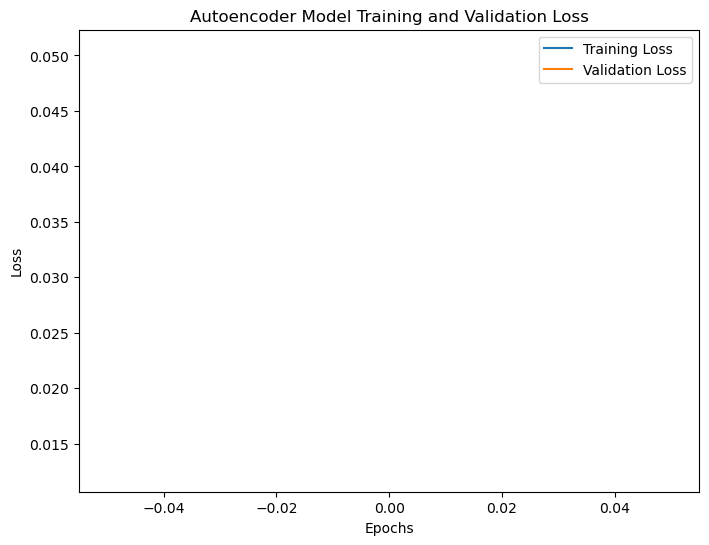

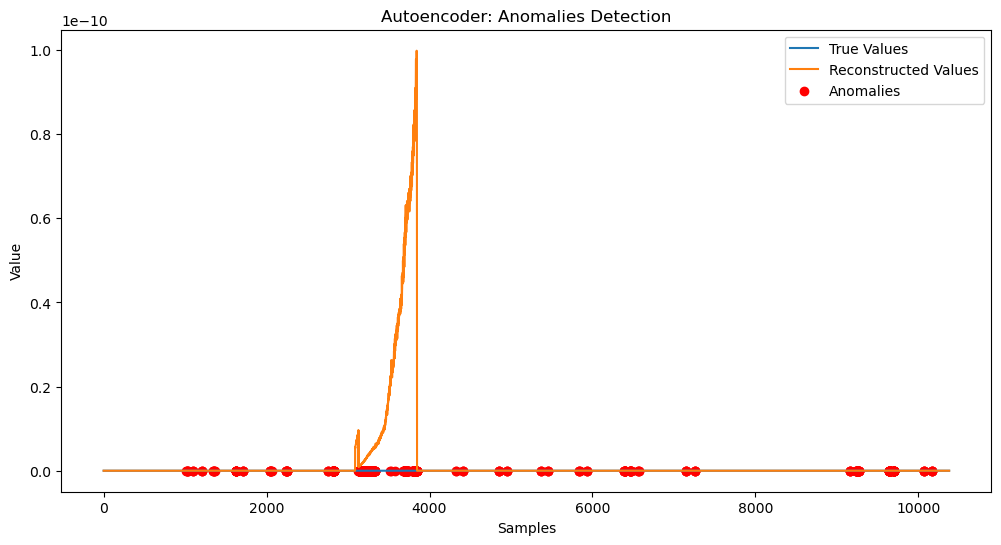

In [19]:
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.preprocessing import MinMaxScaler



# Flatten the data
input_dim = scaled_data.shape[1]

# Define the Autoencoder model
input_layer = Input(shape=(input_dim,))
encoder = Dense(128, activation='relu')(input_layer)
encoder = Dense(64, activation='relu')(encoder)
decoder = Dense(128, activation='relu')(encoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Split the data into training and testing sets
train_size = int(0.9 * len(scaled_data))
X_train = scaled_data[:train_size]
X_test = scaled_data[train_size:]

# Train the Autoencoder
history_autoencoder = autoencoder.fit(X_train, X_train, epochs=1, batch_size=64, validation_data=(X_test, X_test), verbose=2)

# Detect anomalies
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)
anomaly_threshold = np.percentile(mse, 95)
anomalies = mse > anomaly_threshold

# Plot training loss and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history_autoencoder.history['loss'], label='Training Loss')
plt.plot(history_autoencoder.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot true vs reconstructed values with anomalies
plt.figure(figsize=(12, 6))
true_values = scaler.inverse_transform(X_test)[:, selected_columns.index('Error Code')]
reconstructed_values = scaler.inverse_transform(reconstructions)[:, selected_columns.index('Error Code')]
plt.plot(true_values, label='True Values')
plt.plot(reconstructed_values, label='Reconstructed Values')
plt.scatter(np.where(anomalies)[0], true_values[anomalies], color='red', label='Anomalies')
plt.title('Autoencoder: Anomalies Detection')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()
plt.show()

4. Isolation Forest:


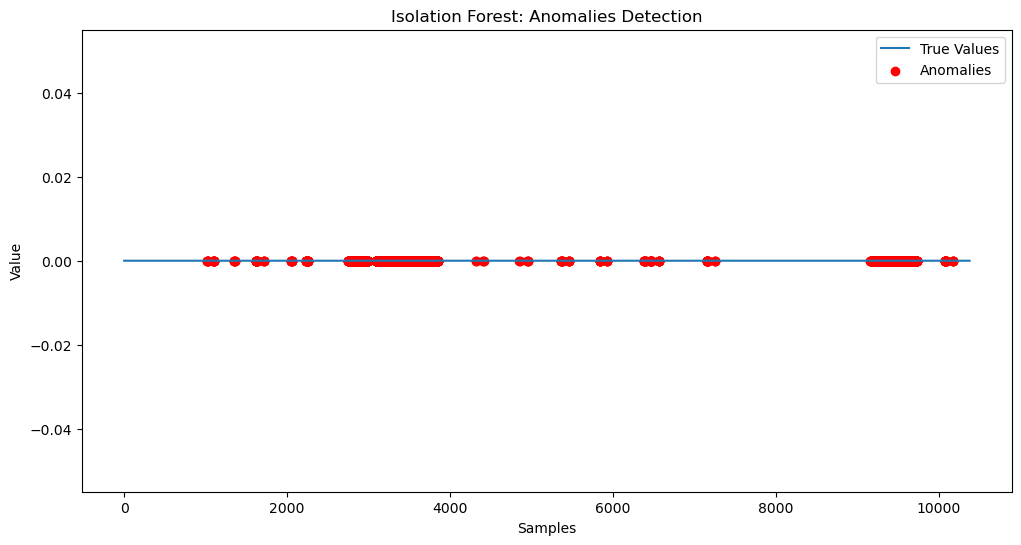

In [22]:
# Fit the Isolation Forest model
isolation_forest = IsolationForest(contamination=0.1)
isolation_forest.fit(X_train)

# Predict anomalies with Isolation Forest
y_pred_train = isolation_forest.predict(X_train)
y_pred_test = isolation_forest.predict(X_test)

# -1 for anomalies, 1 for normal data
anomalies_isolation_forest = y_pred_test == -1

# Inverse transform the test data for visualization
y_test_inverse = scaler.inverse_transform(X_test)[:, selected_columns.index('Error Code')]


# Plot Isolation Forest anomalies
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='True Values')
plt.scatter(np.where(anomalies_isolation_forest)[0], y_test_inverse[anomalies_isolation_forest], color='red', label='Anomalies')
plt.title('Isolation Forest: Anomalies Detection')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()
plt.show()

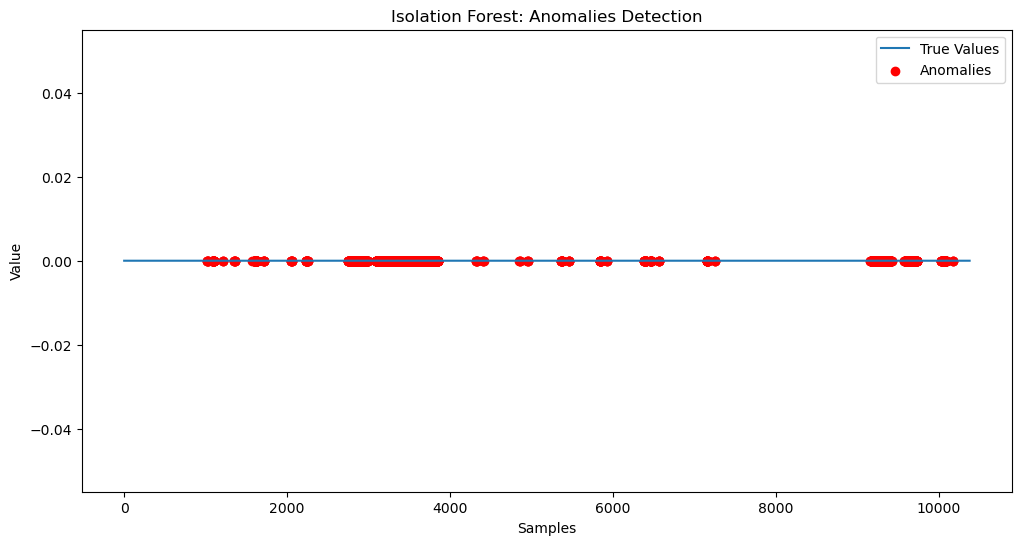

In [23]:
from sklearn.ensemble import IsolationForest

# Fit the model
isolation_forest = IsolationForest(contamination=0.1)
isolation_forest.fit(X_train.reshape(X_train.shape[0], -1))

# Predict anomalies
y_pred_train = isolation_forest.predict(X_train.reshape(X_train.shape[0], -1))
y_pred_test = isolation_forest.predict(X_test.reshape(X_test.shape[0], -1))

# -1 for anomalies, 1 for normal data
anomalies_train = y_pred_train == -1
anomalies_test = y_pred_test == -1

#4. Isolation Forest Model Visualization:
# Predict anomalies
y_pred_test = isolation_forest.predict(X_test.reshape(X_test.shape[0], -1))

# -1 for anomalies, 1 for normal data
anomalies_test = y_pred_test == -1

# Plot true vs predicted values with anomalies
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='True Values')
plt.scatter(np.where(anomalies_test)[0], y_test_inverse[anomalies_test], color='red', label='Anomalies')
plt.title('Isolation Forest: Anomalies Detection')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()
plt.show()



5. One-Class SVM:


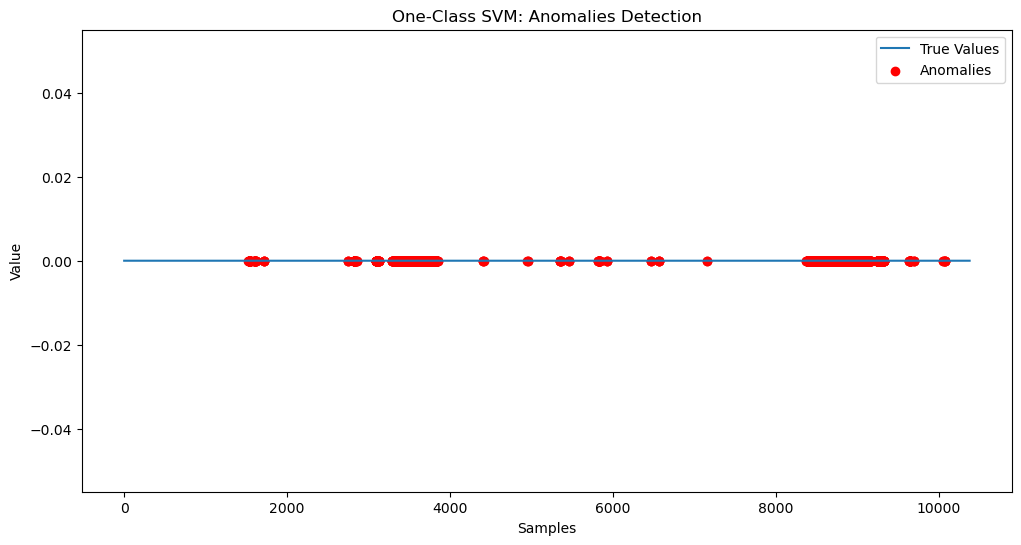

In [24]:
from sklearn.svm import OneClassSVM

# Fit the model
ocsvm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.05)
ocsvm.fit(X_train.reshape(X_train.shape[0], -1))

# Predict anomalies
y_pred_train = ocsvm.predict(X_train.reshape(X_train.shape[0], -1))
y_pred_test = ocsvm.predict(X_test.reshape(X_test.shape[0], -1))

# -1 for anomalies, 1 for normal data
anomalies_train = y_pred_train == -1
anomalies_test = y_pred_test == -1


#5. One-Class SVM Model Visualization:
# Predict anomalies
y_pred_test = ocsvm.predict(X_test.reshape(X_test.shape[0], -1))

# -1 for anomalies, 1 for normal data
anomalies_test = y_pred_test == -1

# Plot true vs predicted values with anomalies
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='True Values')
plt.scatter(np.where(anomalies_test)[0], y_test_inverse[anomalies_test], color='red', label='Anomalies')
plt.title('One-Class SVM: Anomalies Detection')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()
plt.show()
